In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from tqdm import tqdm
import os

In [16]:
IMAGE_PATH = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/images"
MASK_PATH  = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/masks"

image_files = sorted(os.listdir(IMAGE_PATH), key=lambda x: int(x.split('.')[0]))

print("Total images found:", len(image_files))

Total images found: 3064


In [17]:

def preprocess(img):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    norm = cv2.normalize(blur, None, 0, 255, cv2.NORM_MINMAX)
    return norm

In [18]:
def otsu(img):
    t = threshold_otsu(img)
    mask = img > t
    return mask.astype(np.uint8)

def sauvola(img):
    t = threshold_sauvola(img, window_size=25, k=0.3)
    mask = img > t
    return mask.astype(np.uint8)

In [19]:
def clean_mask(mask):
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def largest(mask):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest_label).astype(np.uint8)
    return mask

In [20]:
def dice_score(pred, gt):
    intersection = np.sum(pred * gt)
    return (2. * intersection) / (np.sum(pred) + np.sum(gt) + 1e-7)

def jaccard_index(pred, gt):
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection
    return intersection / (union + 1e-7)

In [21]:
dice_otsu_list = []
dice_sauvola_list = []

iou_otsu_list = []
iou_sauvola_list = []

print("\nEvaluating on full dataset...\n")



Evaluating on full dataset...



In [22]:
for sample in tqdm(image_files):

    img_path = os.path.join(IMAGE_PATH, sample)
    mask_path = os.path.join(MASK_PATH, sample)

    img = cv2.imread(img_path, 0)
    gt  = cv2.imread(mask_path, 0)

    if img is None or gt is None:
        continue

    gt = (gt > 0).astype(np.uint8)

    img_p = preprocess(img)

    # Otsu segmentation
    otsu_mask = largest(clean_mask(otsu(img_p)))

    # Sauvola segmentation
    sauvola_mask = largest(clean_mask(sauvola(img_p)))

    # Compute Dice
    dice_otsu_list.append(dice_score(otsu_mask, gt))
    dice_sauvola_list.append(dice_score(sauvola_mask, gt))

    # Compute Jaccard (IoU)
    iou_otsu_list.append(jaccard_index(otsu_mask, gt))
    iou_sauvola_list.append(jaccard_index(sauvola_mask, gt))

100%|██████████| 3064/3064 [01:10<00:00, 43.56it/s]


In [23]:
print("\n  FINAL RESULTS ")

print("\nTotal Images Evaluated:", len(dice_otsu_list))

print("\n OTSU ")
print("Average Dice     :", np.mean(dice_otsu_list))
print("Average Jaccard  :", np.mean(iou_otsu_list))

print("\n SAUVOLA ")
print("Average Dice     :", np.mean(dice_sauvola_list))
print("Average Jaccard  :", np.mean(iou_sauvola_list))



  FINAL RESULTS 

Total Images Evaluated: 3064

 OTSU 
Average Dice     : 0.07095145961006802
Average Jaccard  : 0.03777037725904814

 SAUVOLA 
Average Dice     : 0.058670978093000356
Average Jaccard  : 0.031138709701507172


In [24]:
sample = image_files[50]

img = cv2.imread(os.path.join(IMAGE_PATH, sample), 0)
gt  = cv2.imread(os.path.join(MASK_PATH, sample), 0)
gt = (gt > 0).astype(np.uint8)

img_p = preprocess(img)

otsu_mask = largest(clean_mask(otsu(img_p)))
sauvola_mask = largest(clean_mask(sauvola(img_p)))


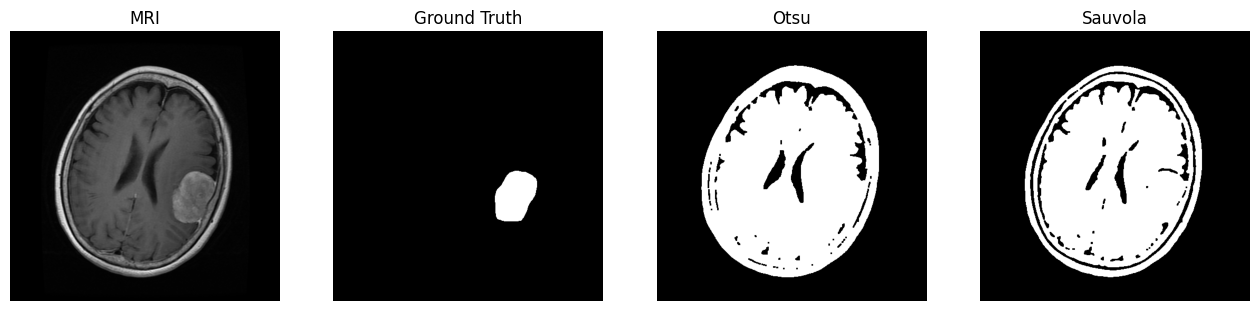

In [25]:
plt.figure(figsize=(16,8))

plt.subplot(1,4,1)
plt.title("MRI")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(gt, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title("Otsu")
plt.imshow(otsu_mask, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title("Sauvola")
plt.imshow(sauvola_mask, cmap='gray')
plt.axis('off')
plt.show()